<a href="https://colab.research.google.com/github/karsarobert/Deep-Learning-2022/blob/main/06/PTE_DL6_FE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning gyakorlat


## 6. gyakorlat: transfer learning
### 2022. október 12.

forrás: https://github.com/mrdbourke/tensorflow-deep-learning

#transfer learning, Feature Extraction

Építettünk egy csomó konvolúciós neurális hálózatot a semmiből, és úgy tűnik, hogy mind tanulnak, azonban még mindig rengeteg lehetőség van a fejlődésre.

A modell(ek) javításához eltölthetünk egy kis időt különböző konfigurációk kipróbálásával, több réteg hozzáadásával, a tanulási sebesség megváltoztatásával, a rétegenkénti neuronok számának beállításával és még sok mással.

Ennek elvégzése azonban nagyon időigényes.

Szerencsére van egy technika, amellyel időt takaríthatunk meg.

Ezt **transzfer-tanulásnak** hívják, más szóval, egy másik modell által egy másik problémából megtanult mintákat (más néven súlyokat) veszünk, és felhasználjuk a saját problémánkhoz.

A transzfer tanulás alkalmazásának két fő előnye van:
1. Felhasználhatunk egy meglévő neurális hálózati architektúrát, amely bizonyítottan működik a miénkhez hasonló problémákon.
2. Olyan működő neurális hálózati architektúrát használhatunk fel, amely **már megtanult** mintákat a miénkhez hasonló adatokon. Ez gyakran azt eredményezi, hogy kevesebb egyedi adattal is nagyszerű eredményeket érhetünk el.

Ez azt jelenti, hogy ahelyett, hogy saját neurális hálózati architektúrát készítenénk vagy a semmiből építenénk, felhasználhatunk olyan modelleket, amelyek másoknál már beváltak.

Ahelyett pedig, hogy a saját modelljeinket a semmiből képeznénk ki saját adathalmazainkon, az olyan adathalmazokból, mint például az [ImageNet](http://www.image-net.org/) (több millió különböző tárgyat ábrázoló kép) tanult mintákat vehetjük alapul, és használhatjuk azokat a saját modelljeink alapjául. Ha így járunk el, gyakran kevesebb adatból is nagyszerű eredményeket érhetünk el.


## GPU használata

Először is ellenőrizzük, hogy használunk-e GPU-t. A GPU használata biztosítja, hogy a modellünk gyorsabban edződjön, mintha csak a CPU-t használnánk.


In [ ]:
# Are we using a GPU?
!nvidia-smi

Tue Oct 11 17:57:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Ha a fenti cella nem ad ki valamit, ami úgy néz ki, mint:

```
Fri Sep  4 03:35:21 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU   GI   CI        PID   Type   Process name                  GPU Memory |
|        ID   ID                                                   Usage      |
|=============================================================================|
|  No running processes found                                                 |
+-----------------------------------------------------------------------------+
```

Menj a Futtatókörnyezet -> Futtatókörnyezet módosítása -> Hardveres gyorsítás és válaszd a "GPU" lehetőséget, majd futtasd újra a fenti cellát.

## Transfer learning (transzfer tanulás) TensorFlow Hub segítségével: Nagyszerű eredmények elérése az adatok 10%-ával

Sok olyan problémára, amelyre a mélytanulást szeretné használni, jó eséllyel már létezik egy működő modell.

És a jó hír az, hogy ezek közül sokhoz hozzáférhet a TensorFlow Hubon.

A [TensorFlow Hub](https://tfhub.dev/) a meglévő modellkomponensek tárháza. Ez teszi lehetővé, hogy egy teljesen betanított modellt importálhasson és használhasson, mindössze egy URL segítségével.

Ehhez mi lenne, ha azt mondanám, hogy az eredeti adatok mindössze 10%-ával, vagyis 10x kevesebb adattal is nagyjából ugyanazokat az eredményeket (vagy jobbakat) kaphatnánk, mint amit a legjobb modellünk eddig elért.

Ez ellentmondásosnak tűnik, igaz?

Nem gondolná, hogy több példa arra, hogyan néz ki egy étel képe, jobb eredményekhez vezet?

És igazad lenne, ha így gondolnád, általában a több adat jobb eredményekhez vezet.

Mi van azonban, ha nincs több adat? Mi lenne, ha osztályonként 750 kép helyett csak 75 kép lenne osztályonként?

Egy adott osztályból 675 további kép összegyűjtése hosszú időt vehetne igénybe.

Itt jön tehát a képbe a transzfer tanulás másik nagy előnye.

**A transzfer tanulás gyakran lehetővé teszi, hogy kevesebb adattal is nagyszerű eredményeket érjünk el.

Töltsük le az általunk használt adatok egy részhalmazát, nevezetesen a `10_food_classes` adathalmaz képzési adatainak 10%-át, és használjuk azt egy ételkép-osztályozó betanítására.

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/04-transfer-learning-feature-extraction.png)


## Adatok letöltése

In [ ]:
# Get data (10% of labels)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-10-11 17:57:27--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 74.125.24.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M  37.9MB/s    in 4.2s    

2022-10-11 17:57:32 (37.9 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [ ]:
# Hány kép van az egyes mappákban?
import os

# Menjünk végig a 10 százalékos adatkönyvtáron
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test

Figyelje meg, hogy a képzési könyvtárak mindegyike 750 kép helyett 75 képet tartalmaz. Ez kulcsfontosságú annak bemutatásához, hogy a transzfer tanulás milyen jól működik kevesebb címkézett kép esetén.

A tesztkönyvtárak továbbra is ugyanannyi képet tartalmaznak. Ez azt jelenti, hogy kevesebb adaton fogunk gyakorolni, de a modelljeinket ugyanannyi tesztadaton fogjuk kiértékelni.

## Adattöltők létrehozása (az adatok előkészítése)

Most, hogy letöltöttük az adatokat, használjuk a [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) osztályt a `flow_from_directory` metódussal együtt a képeink betöltésére.

In [ ]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


Kiváló! Az adatok betöltése után láthatjuk, hogy a képzési adathalmazban 750 kép van, amelyek 10 osztályba tartoznak (osztályonként 75), és 2500 kép van a teszthalmazban, amelyek 10 osztályba tartoznak (osztályonként 250).

## Modellek létrehozása a TensorFlow Hub segítségével

A múltban a TensorFlow segítségével rétegről rétegre, a semmiből hoztuk létre saját modelljeinket.

Most egy hasonló folyamatot fogunk elvégezni, azzal a különbséggel, hogy a modellünk rétegeinek többsége a [TensorFlow Hub](https://tfhub.dev/) forrásból fog származni.

Valójában két modellt fogunk használni a TensorFlow Hubból:
1. [ResNetV2](https://arxiv.org/abs/1603.05027) - a legmodernebb számítógépes látás modellarchitektúra 2016-ból.
2. [EfficientNet](https://arxiv.org/abs/1905.11946) - egy legkorszerűbb számítógépes látás modellarchitektúra 2019-ből.

A legkorszerűbb állapot azt jelenti, hogy valamikor mindkét modell elérte a legalacsonyabb hibaarányt az [ImageNet (ILSVRC-2012-CLS)](http://www.image-net.org/), a számítógépes látás benchmarkok arany standardján.

Talán elgondolkodik azon, hogy hogyan találja meg ezeket a modelleket a TensorFlow Hubon?

Lépések:

1. Menj a [tfhub.dev](https://tfhub.dev/) oldalra.
2. Válaszd ki a problémád tartományát, pl. "Image" (mi ételképeket használunk).
3. Válassza ki a TF verzióját, ami a mi esetünkben a TF2.
4. Távolítsuk el az összes "Problem domanin" szűrőt, kivéve azt a problémát, amin dolgozunk. 
  * **Jegyzet:** A "Image feature vector" szinte bármilyen probléma mellett használható, erre hamarosan rátérünk.
5. A felsorolt modellek mind olyan modellek, amelyek potenciálisan felhasználhatók az Ön problémájához.

> 🤔 **Kérdés:** *A képosztályozási modellek között sok lehetőséget látok, honnan tudom, melyik a legjobb?*

A legmodernebb modellek listáját a [paperswithcode.com](https://www.paperswithcode.com) oldalon tekintheti meg, amely a legfrissebb mélytanulási papírok eredményeinek gyűjtésére szolgáló forrás, amely az általuk közölt eredményekhez kódos implementációkat is tartalmaz.

Mivel mi képekkel dolgozunk, a célpontunk az [ImageNet-en legjobban teljesítő modellek](https://paperswithcode.com/sota/image-classification-on-imagenet).

Valószínűleg a paperswithcode-on felsorolt modellarchitektúrák közül nem mindegyik jelenik meg a TensorFlow Hub-on. És ez nem baj, attól még használhatjuk, ami elérhető.

Ahhoz, hogy megtaláljuk a modelljeinket, szűkítsük le a keresést az Architecture fül segítségével.

6. Válasszuk ki a TensorFlow Hubon az Architecture lapot, és megjelenik egy legördülő menü az architektúrák neveivel. 
  * Az ökölszabály itt általában az, hogy a nagyobb számmal ellátott nevek jobb teljesítményű modelleket jelentenek. Például az EfficientNetB4 jobban teljesít, mint az EfficientNetB0.
    * A nagyobb számok azonban azt jelenthetik, hogy hosszabb ideig tart a számításuk. 
7. Válassza ki az EfficientNetB0-t, és [valami hasonlót kell látnia](https://tfhub.dev/s?module-type=image-classification,image-feature-vector&network-architecture=efficientnet-b0&tf-version=tf2):
![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/04-tensorflow-hub-efficientnetb0.png)
8. Az "[efficientnet/b0/feature-vector](https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1)" címre kattintva egy olyan oldalra jutunk, ahol egy "Copy URL" gomb található. Ezt az URL-t használhatjuk az EfficientNetB0 erejének kihasználására.
  * Az URL másolásával valami ilyesmit kapunk: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

1. **A "változatlan" transzfer tanulás** az, amikor egy előre betanított modellt úgy veszünk, ahogy van, és változtatás nélkül alkalmazzuk a feladatra. 

  * Például sok számítógépes látásmodellt az ImageNet adathalmazon tanítanak be, amely 1000 különböző képosztályt tartalmaz. Ez azt jelenti, hogy egyetlen képet átadva a modellnek, 1000 különböző előrejelzési valószínűségi értéket kapunk (minden osztályhoz 1 értéket). 

    * Ez hasznos, ha 1000 osztálynyi képet szeretne osztályozni, és ezek mindegyike megegyezik az ImageNet osztályaival, azonban nem hasznos, ha csak az osztályok egy kis részhalmazát szeretné osztályozni (például 10 különböző ételfajtát). A TensorFlow Hubon a `"/classification"-t a nevükben tartalmazó modellek biztosítják ezt a fajta funkcionalitást.

2. **Tulajdonság-kivonás transzfer tanulás** az, amikor az előzetesen betanított modell által megtanult alapmintákat (más néven súlyokat) felhasználja, és a kimeneteit úgy módosítja, hogy azok jobban megfeleljenek a problémának. 

  * Tegyük fel például, hogy az Ön által használt előképzett modell 236 különböző réteggel rendelkezik (az EfficientNetB0 236 réteggel rendelkezik), de a legfelső réteg 1000 osztályt ad ki, mivel az ImageNet-en előképzett. Ahhoz, hogy ezt a saját problémájához igazítsa, eltávolíthatja az eredeti aktiválási réteget, és helyettesítheti a sajátjával, de a megfelelő számú kimeneti osztállyal. A fontos része itt az, hogy **csak a legfelső néhány réteg válik edzhetővé, a többi megmarad befagyasztva**. 

    * Így az összes mögöttes minta megmarad a többi rétegben, és ezeket felhasználhatja a saját problémájához. Ez a fajta transzfer tanulás nagyon hasznos, ha az Ön adatai hasonlóak azokhoz az adatokhoz, amelyeken a modellt előtanították.

3. **Finomhangoló transzfer tanulás** az, amikor az előzetesen betanított modell alapjául szolgáló mintákat (más néven súlyokat) a saját problémájához igazítja (finomhangolja). 

    * Ez általában azt jelenti, hogy az előzetesen betanított modellben lévő rétegek közül **néhányat, sokat vagy az összeset** betanítjuk. Ez akkor hasznos, ha nagy adathalmazzal rendelkezünk (pl. 100+ kép osztályonként), ahol az adataink kissé eltérnek az eredeti modell által betanított adatoktól.

Gyakori munkafolyamat, hogy az előképzett modell alsó rétegeiben lévő összes tanult mintát "befagyasztjuk", így azok nem képezhetők. Ezután a felső 2-3 réteget képezzük ki, hogy az előképzett modell a kimeneteit az egyéni adatokhoz igazíthassa (**jellemzők kinyerése**).

Miután a felső 2-3 réteget betanította, fokozatosan "feloldhatja" az újabb és újabb rétegeket, és lefuttathatja a betanítási folyamatot a saját adatain, hogy tovább **finomítsa** az előbetanított modellt.

> 🤔 **Kérdés:** *Miért csak a felső 2-3 réteget képezzük ki a jellemző-kivonás során?*

Minél lejjebb van egy réteg egy számítógépes látásmodellben, mint például minél közelebb van a bemeneti réteghez, annál nagyobbak a megtanulható jellemzők. Például egy macskák vagy kutyák képeit azonosító számítógépes látásmodell alsó rétege megtanulhatja a lábak körvonalát, míg a kimenethez közelebbi rétegek megtanulhatják a fogak alakját. Gyakran azt szeretné, ha a nagyobb jellemzők (a megtanult mintákat is jellemzőknek nevezik) megmaradnának, mivel ezek mindkét állat esetében hasonlóak, míg a különbségek a finomabb szemcséjű jellemzőkben maradnak meg.

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/04-different-kinds-of-transfer-learning.png)
*A transzfer tanulás különböző fajtái. Egy eredeti modell, egy feature extraction modell (csak a felső 2-3 réteg változik) és egy finomhangoló modell (az eredeti modell sok vagy az egész modell változik).*.


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

Most a fenti lépések segítségével a TensorFlow Hubból két elterjedt számítógépes látás architektúra, az [EfficientNetB0 (2019)](https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1) és a [ResNetV250 (2016)](https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4) jellemzővektor URL-jét fogjuk megszerezni.

Mindkettőt azért szerezzük be, mert össze fogjuk hasonlítani őket, hogy megnézzük, melyik teljesít jobban a mi adatainkon.

> 🔑 **Megjegyzés:** A különböző modellarchitektúrák teljesítményének összehasonlítása ugyanazon adatokon nagyon gyakori gyakorlat. Ennek egyszerű oka az, hogy tudni akarjuk, melyik modell teljesít a legjobban a problémánkhoz.

> **frissítés:** 2021. augusztus 14-től az [EfficientNet V2 előképzett modelljei elérhetőek a TensorFlow Hubon](https://tfhub.dev/google/collections/efficientnet_v2/1). Az eredeti kód ebben a jegyzetfüzetben az EfficientNet V1-et használja, azt változatlanul hagytuk. Az [ezzel az adatkészlettel végzett kísérleteim](https://github.com/mrdbourke/tensorflow-deep-learning/discussions/166) során a V1 felülmúlja a V2-t. A legjobb, ha a saját adataiddal kísérletezel, és meglátod, mi felel meg neked.

In [ ]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

Ezek az URL-címek a TensorFlow Hubon lévő, elmentett, előzetesen betanított modellre mutatnak.

Amikor a modellünkben használjuk őket, a modell automatikusan letöltődik, hogy használhassuk.

Ehhez használhatjuk a [`KerasLayer()`](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) modellt a TensorFlow hub könyvtáron belül.

Mivel két modellt fogunk összehasonlítani, hogy megspóroljuk magunknak a kódot, létrehozunk egy `create_model()` függvényt. Ez a függvény fogadja egy modell TensorFlow Hub URL címét, instatiál egy Keras szekvenciális modellt a megfelelő számú kimeneti réteggel, és visszaadja a modellt.

In [ ]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
  ])

  return model

Most már van egy függvényünk a modell létrehozására, először is létrehozunk vele egy modellt, amely a ResNetV250 architektúrát használja a jellemzőkivonó rétegként.

Miután a modellt instanciáltuk, összeállítjuk azt a `categorical_crossentropy` mint veszteségfüggvényt, az Adam optimalizálót és a pontosságot mint metrikát használva.

In [ ]:
# Create model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/04-resnet-feature-extractor.png)
*Hogyan néz ki a jelenlegi modellünk. Egy ResNet50V2 gerinchálózat egy egyedi sűrű réteggel a tetején (10 osztály az 1000 ImageNet osztály helyett). **Jegyzet:** A képen ResNet50 helyett ResNet34 látható. **Kép forrása:** https://arxiv.org/abs/1512.03385.*

Ideje illeszteni a modellt.

Készen vannak a képzési adatok a `train_data_10_percent`, valamint a tesztadatok, amelyeket `test_data` néven mentettünk el.

Tartsuk ezt a kísérletet rövidnek, és 5 epochán keresztül eddzünk.

In [ ]:
## Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data))
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  #callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                        # experiment_name="resnet50V2")]) # name of log files

Epoch 1/5
24/24 [==============================] - 24s 756ms/step - loss: 1.9023 - accuracy: 0.3640 - val_loss: 1.1920 - val_accuracy: 0.6108
Epoch 2/5
24/24 [==============================] - 16s 677ms/step - loss: 0.8886 - accuracy: 0.7253 - val_loss: 0.8659 - val_accuracy: 0.7268
Epoch 3/5
24/24 [==============================] - 16s 668ms/step - loss: 0.6132 - accuracy: 0.8267 - val_loss: 0.7588 - val_accuracy: 0.7572
Epoch 4/5
24/24 [==============================] - 16s 692ms/step - loss: 0.4679 - accuracy: 0.8853 - val_loss: 0.7100 - val_accuracy: 0.7760
Epoch 5/5
24/24 [==============================] - 16s 698ms/step - loss: 0.3798 - accuracy: 0.9093 - val_loss: 0.6751 - val_accuracy: 0.7824


Hűha! 

Úgy tűnik, hogy mindössze 5 epocha után a ResNetV250 jellemző-kivonó modell képes volt minden általunk készített architektúrát kiütni a vízből, 90% körüli pontosságot ért el a gyakorlóhalmazon és közel 80%-os pontosságot a teszthalmazon... **a gyakorló képek mindössze 10%-ával!**.

Ez jól mutatja a transzfer tanulás erejét. És ez az egyik fő oka annak, hogy amikor saját adathalmazokat próbál modellezni, érdemes megnézni, milyen előképzett modellek léteznek már.

Nézzük meg a modellünk képzési görbéit a `plot_loss_curves` függvény segítségével.

In [ ]:
# If you wanted to, you could really turn this into a helper function to load in with a helper.py script...
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

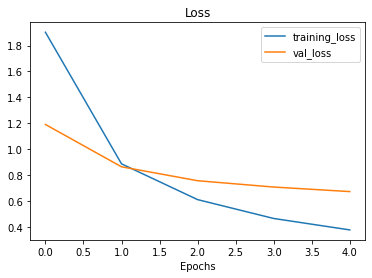

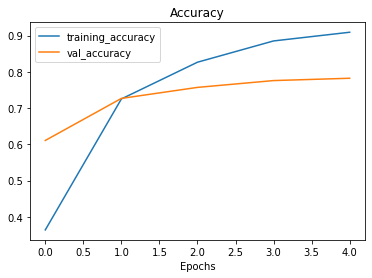

In [ ]:
plot_loss_curves(resnet_history)

And what about a summary of our model?

In [ ]:
# Resnet summary 
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


A TensorFlow Hub teljesítményét itt tekintheti meg. A jellemzőkinyerő réteg 23 564 800 paraméterrel rendelkezik, amelyek előre megtanult minták, amelyeket a modell már megtanult az ImageNet adathalmazon. Mivel a `trainable=False` értéket állítottuk be, ezek a minták a képzés során befagyasztva maradnak (nem taníthatóak).

Ez azt jelenti, hogy a modell a képzés során a kimeneti rétegben lévő 20 490 paramétert frissíti a mi adatállományunknak megfelelően.

Oké, betanítottunk egy ResNetV250 modellt, ideje ugyanezt megtenni az EfficientNetB0 modellel.

A beállítás pontosan ugyanaz lesz, mint korábban, kivéve a `model_url` paramétert a `create_model()` függvényben.

In [ ]:
# Create model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model 
efficientnet_history = efficientnet_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=10, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data))
                                    

Epoch 1/10
24/24 [==============================] - 24s 700ms/step - loss: 1.8124 - accuracy: 0.4533 - val_loss: 1.2555 - val_accuracy: 0.7516
Epoch 2/10
24/24 [==============================] - 15s 634ms/step - loss: 1.0360 - accuracy: 0.7720 - val_loss: 0.8398 - val_accuracy: 0.8264
Epoch 3/10
24/24 [==============================] - 15s 635ms/step - loss: 0.7437 - accuracy: 0.8293 - val_loss: 0.6744 - val_accuracy: 0.8496
Epoch 4/10
24/24 [==============================] - 15s 635ms/step - loss: 0.5971 - accuracy: 0.8600 - val_loss: 0.5932 - val_accuracy: 0.8584
Epoch 5/10
24/24 [==============================] - 15s 639ms/step - loss: 0.5062 - accuracy: 0.8973 - val_loss: 0.5411 - val_accuracy: 0.8660
Epoch 6/10
24/24 [==============================] - 15s 636ms/step - loss: 0.4380 - accuracy: 0.9067 - val_loss: 0.5059 - val_accuracy: 0.8748
Epoch 7/10
24/24 [==============================] - 15s 636ms/step - loss: 0.3894 - accuracy: 0.9240 - val_loss: 0.4807 - val_accuracy: 0.8748

Szent ég! Az EfficientNetB0 modell még jobban teljesít, mint a ResNetV250 modell! Több mint 85%-os pontosságot ér el a tesztkészleten... ismét **a képzési adatok mindössze 10%-ával**.

Milyen király ez?

Néhány sornyi kóddal képesek vagyunk kihasználni a legmodernebb modelleket, és a saját felhasználási esetünkhöz igazítani őket.

Nézzük meg a veszteséggörbéket.

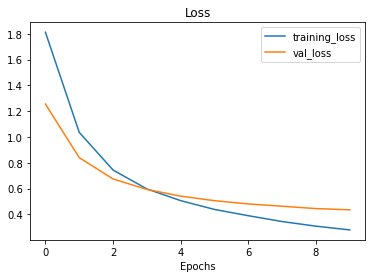

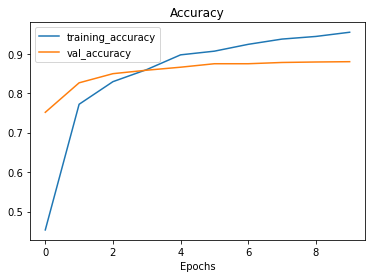

In [ ]:
plot_loss_curves(efficientnet_history)

Az EfficientNetB0 modell veszteséggörbéi alapján úgy tűnik, hogy ha tovább tanítanánk a modellünket, még tovább javulhatna. Talán ezt ki is próbálhatná?

Nézzük meg a modell összefoglalóját.

In [ ]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


Úgy tűnik, hogy annak ellenére, hogy több mint négyszer kevesebb paraméterrel rendelkezik (4 049 564 vs. 23 564 800), mint a ResNet50V2 extrakciós réteg, az EfficientNetB0 jellemző extrakciós réteg jobb teljesítményt nyújt. Most már világos, honnan származik a "hatékony" elnevezés.

## 📖 Olvasnivaló

* Olvassa át a [TensorFlow Transfer Learning Guide](https://www.tensorflow.org/tutorials/images/transfer_learning) című dokumentumot, és határozza meg saját szavaival a transzfer tanulás két fő típusát.
* Nézd végig a [Transfer Learning with TensorFlow Hub tutorial](https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub) című részt.